stopword + tokenize + pad + embedding din tf

In [21]:
import nltk
import pandas as pd
from textblob import Word
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')

In [3]:
therapis_responses = pd.read_csv("../data/Therapist_responses.csv",delimiter=",")
annotated_data = pd.read_csv("../data/Annotated_data.csv",delimiter=",")
annotated_data_copy = pd.merge(therapis_responses,annotated_data,on='Id_Number')
annotated_data_copy = annotated_data_copy.drop(['Question'],axis=1)

In [4]:
def label_distorsion_binary(row):
    if row["Dominant Distortion"] == "No Distortion":
        return 0
    return 1

annotated_data_copy["Distortion"] = annotated_data_copy.apply(label_distorsion_binary, axis=1)

In [5]:
data_list = annotated_data_copy.values.tolist()
# 0 = ANSWER   ,   1 = ID   ,   2 = QUESTION   ,   3 = DISTORTED PART   ,
# 4 = DOMINANT DISTORTION   ,   5 = SECONDARY DISTORTION   ,   6 = DISTORTION 1/0
data_list[0]

['Thank you for writing. You did nothing wrong! You did not put this woman in prison. She did it to herself. She befriended, manipulated and abused a vulnerable 14-year-old (actually, two young teens). She is a sexual offender who was grooming you, not loving you. She belongs in jail.This was never an equal or appropriate relationship. As a teacher, she used her position of authority and the fact you were needy and looked up to her as means to draw you in. She was so good at gaslighting you that you believed and still believe that her abuse was love. She did all the classic moves of an abuser: She gained control of you by making you think you were special. She isolated you, making you more and more dependent on her. She created a relationship where you were always on eggshells, trying not to say or do anything that would cause a fight. She created fights anyway and then made you feel like you were at fault. Apologies and presents followed — which only confused you more. Any time that y

In [6]:
#data = pd.read_csv('data.csv')
X = [el[2] for el in data_list]
X[:5]

['From a teen in Australia: This story is incredibly long but I’m going to do my best to cut it down and only include the most important bits. When I was 14 and in a very low place, I met a teacher at my school. She was around 30. I didn’t think much of it at first, but eventually I kept talking to her more and more and seeing her around. We grew close quickly and for some reason I just felt connected to her. One day I received a text message from her as she had gotten my number off another student.',
 'From a woman in the U.S.: My Therapist of eight months terminated. {new job}.\xa0 \xa0I cancelled our final appts: because I could not face her. I had lied to her to test her and ultimately push her away.\xa0 She knew I think and I believe she felt betrayed.\xa0 I could tell because our sessions changed… She was in fact pushed away.',
 'I don’t even really know where to start. For the past 7 months I’ve been under extreme mounts of stress followed by a few panic attacks, that have left 

In [7]:
Y = [el[-1] for el in data_list]
Y[:10]

[1, 1, 1, 1, 1, 1, 0, 0, 1, 1]

In [8]:
def cleaning(df, stop_words):
    df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
    # Replacing the digits/numbers
    #df['Sentence'] = df['Sentence'].str.replace('d', '')
    # Removing stop words
    df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatization
    df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))
    return df

stop_words = stopwords.words('english')

In [9]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

In [10]:
X

array([[  0,   0,   0, ...,   4, 185, 223],
       [  0,   0,   0, ...,  10, 431, 179],
       [  0,   0,   0, ...,  15, 274,  79],
       ...,
       [  0,   0,   0, ...,  23, 316,  17],
       [  0,   0,   0, ..., 274,  79,   7],
       [  0,   0,   0, ...,  25,  24, 453]])

In [11]:
Y = np.array(Y)

In [19]:

#Model Building
model = Sequential()
model.add(Embedding(500, 100, input_length = X.shape[1]))#20=120
model.add(SpatialDropout1D(0.4))
model.add(LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='LeakyReLU'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())
#Model Training

#Model Testing

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 789, 100)          50000     
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 789, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 300)               481200    
                                                                 
 dense_6 (Dense)             (None, 64)                19264     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 550,529
Trainable params: 550,529
Non-trainable params: 0
________________________________________________

In [20]:
model.fit(X, Y, epochs = 2)

Epoch 1/2
80/80 [==============================] - 608s 8s/step - loss: 0.6623 - accuracy: 0.6324
Epoch 2/2
80/80 [==============================] - 601s 8s/step - loss: 0.5920 - accuracy: 0.6881


80/80 [==============================] - 92s 1s/step


Text(50.722222222222214, 0.5, 'Truth')

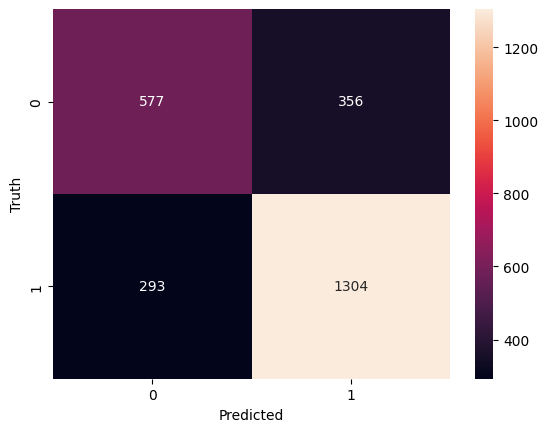

In [22]:
y_predicted = model.predict(X)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5,1,0)
cm = confusion_matrix(Y, y_predicted)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')